In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [2]:
df = pd.read_csv("TempAnomaly_Land.csv")

#string to date format
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,Anomaly
Month,
2000-01-01,0.48
2000-02-01,1.07
2000-03-01,1.15
2000-04-01,1.22
2000-05-01,0.59


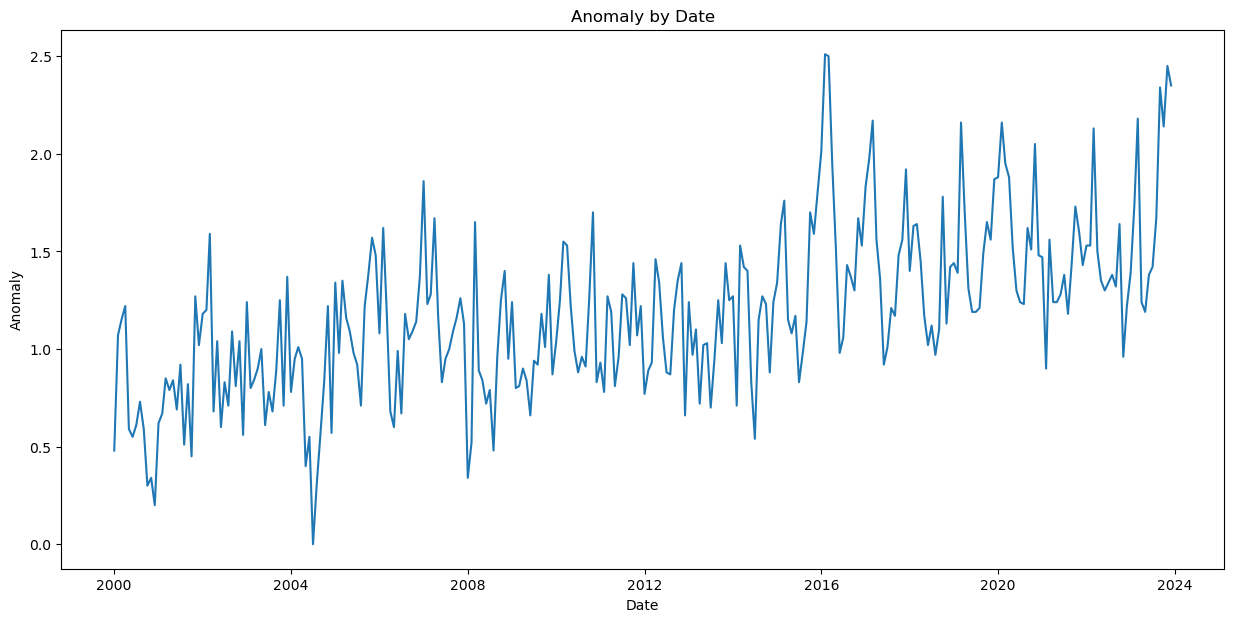

In [3]:
plt.figure(figsize=(15,7))
plt.title("Anomaly by Date")
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.plot(df)
plt.show()

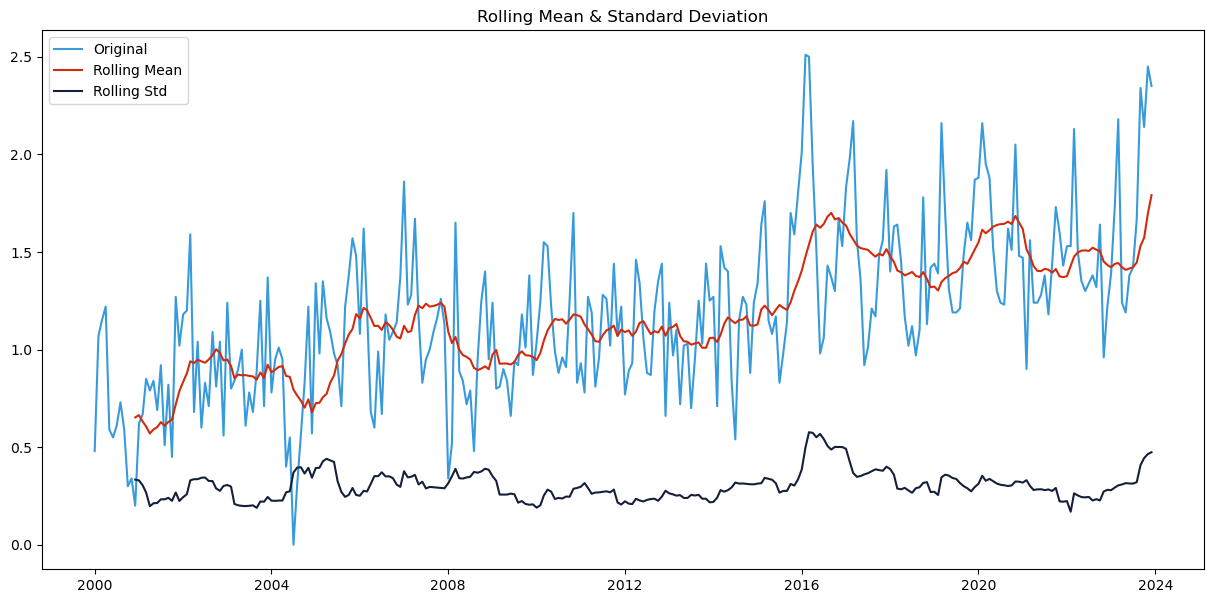

In [4]:
#Determine rolling statistics
df["rolling_avg"] = df["Anomaly"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Anomaly"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Anomaly"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [5]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Anomaly'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.351987
p-value                          0.605066
#Lags Used                      10.000000
Number of Observations Used    277.000000
Critical Value (1%)             -3.454180
Critical Value (5%)             -2.872031
Critical Value (10%)            -2.572360
dtype: float64


In [6]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Anomaly'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 -66.597
Date:                Sat, 27 Apr 2024   AIC                            143.194
Time:                        15:51:36   BIC                            161.508
Sample:                    01-01-2000   HQIC                           150.533
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4231      0.066     21.643      0.000       1.294       1.552
ar.L2         -0.3151      0.110     -2.872      0.004      -0.530      -0.100
ar.L3         -0.1081      0.066     -1.630      0.1

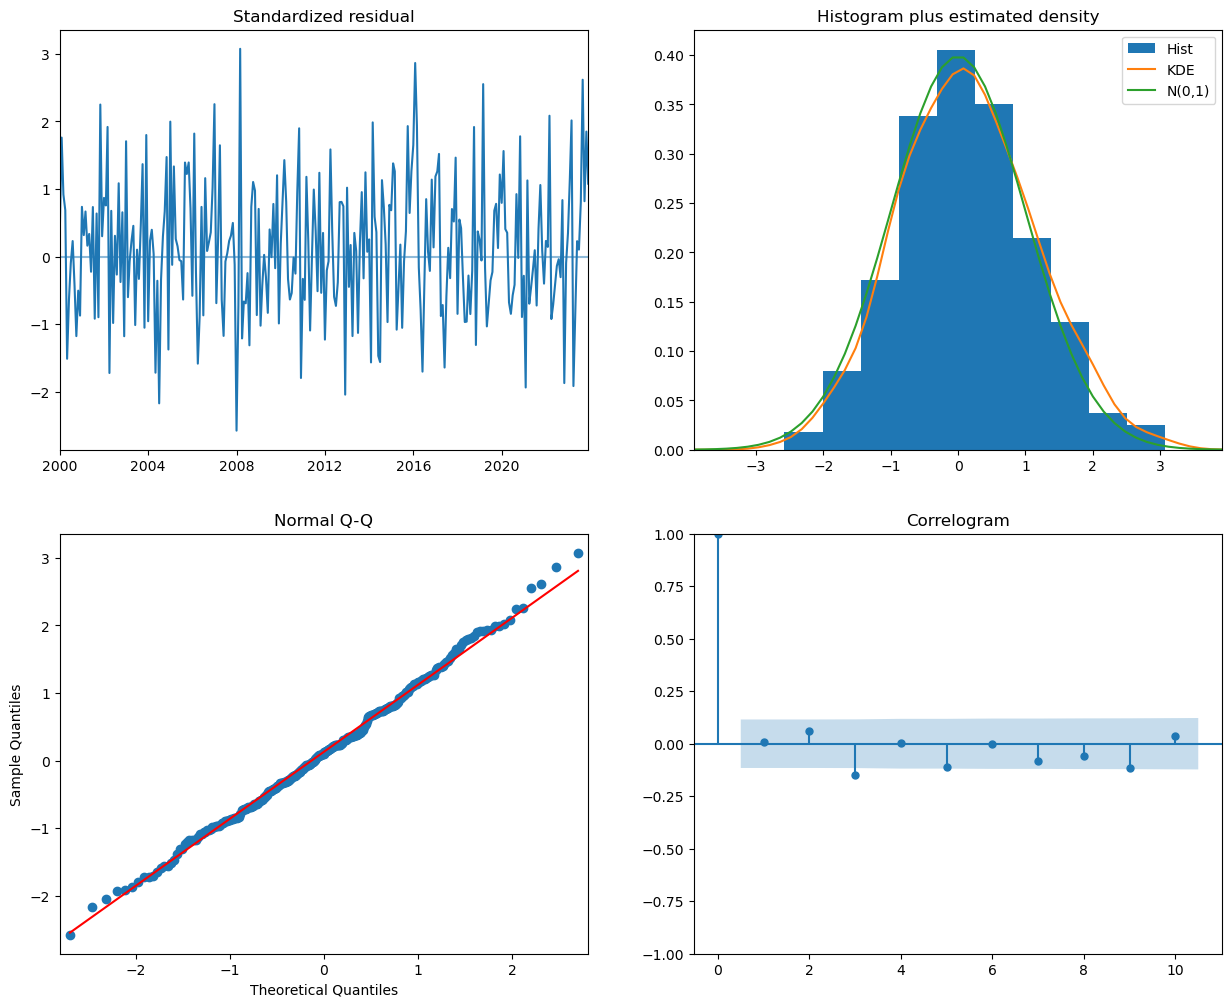

In [7]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

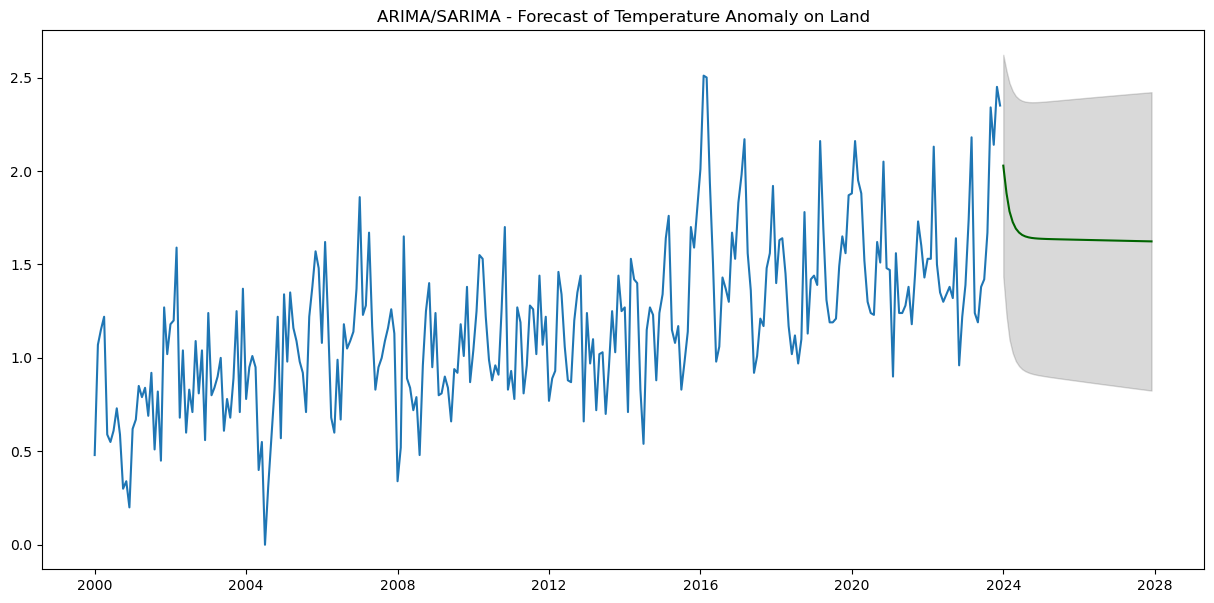

In [8]:
def forecast(ARIMA_model, periods=48):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Anomaly"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Temperature Anomaly on Land")
    plt.show()

forecast(ARIMA_model)

In [9]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["Anomaly"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  288
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 -64.534
Date:                            Sat, 27 Apr 2024   AIC                            141.067
Time:                                    15:51:51   BIC                            162.790
Sample:                                01-01-2000   HQIC                           149.784
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0395      0.020      2.009      0.045       0.001       0.078
ar.L1          0.3184      0.058      5.495      0.000       0.205       0.432
ar.L2          0.2427      0.058      4.212      0.000       0.130       0.356
ar.S.L12      -0.7615      0.058    -13.095      0.000      -0.875      -0.648
ar.S.L24      -0.3395      0.065     -5.209      0.000      -0.467      -0.212
sigma2         0.0908      0.007     12.451      0.000       0.077       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.90   Prob(JB):                         0.26
Heteroskedasticity (H):               0.68   Skew:                            -0.10
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

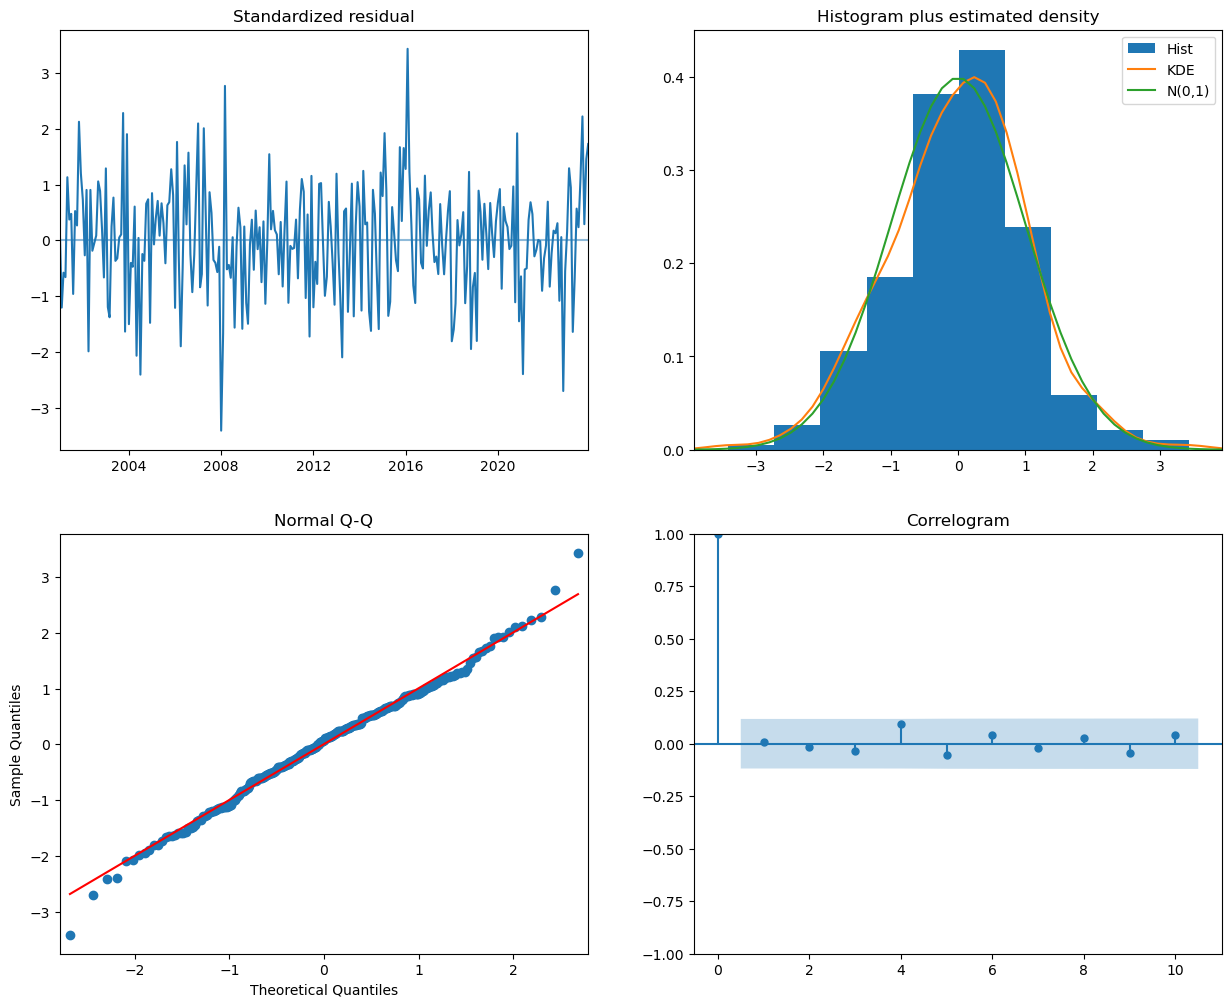

In [10]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

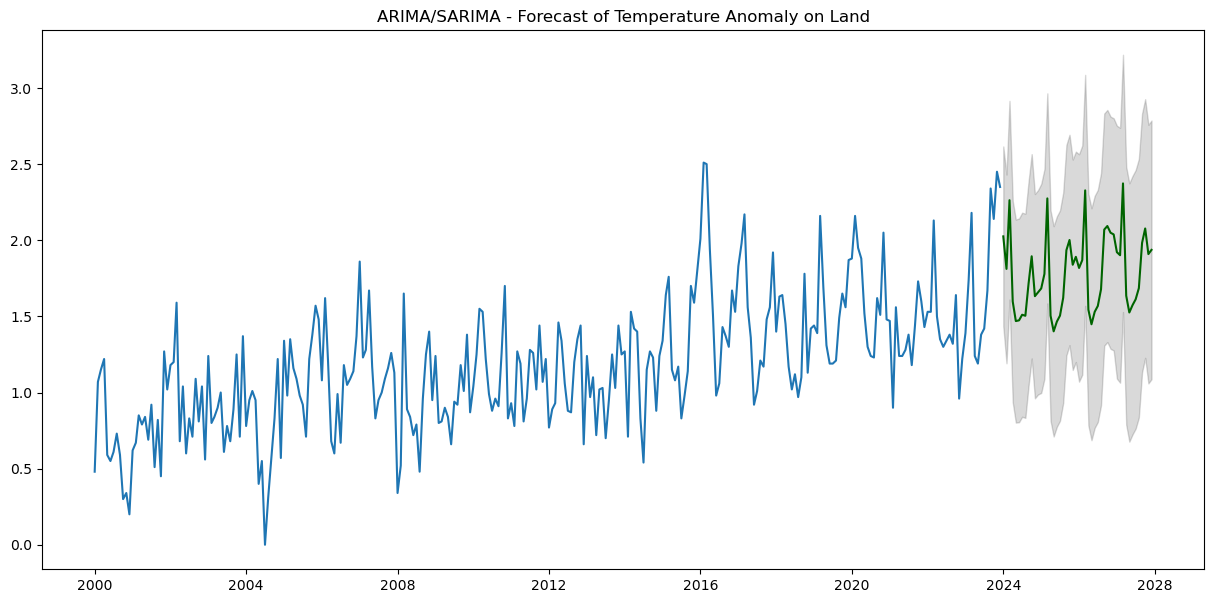

In [11]:
forecast(SARIMA_model)